In [3]:
import pandas as pd
import numpy as np
import pickle
import treecorr
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
sns.set(color_codes=True)

In [5]:
df_riz = pd.read_pickle('/home/cz136/project/balrog/data/mcal{}_df_all.pkl'.format(3)) 

In [6]:
keys = df_riz.columns[40:]
N=300

In [7]:
bs_xi_dict={}
bs_xi_true_dict={}
for key in keys:
    bs_xi_dict[key]=np.load("/home/cz136/project/balrog/data/bootstrap/{}/{}.npy".format(N,key))
    bs_xi_true_dict[key]=np.load("/home/cz136/project/balrog/data/bootstrap/{}/{}_true.npy".format(N,key))

In [15]:
jk_xi_dict={}
jk_xi_true_dict={}

for key in keys:
    jk_xi_dict[key]=np.load("/home/cz136/project/balrog/data/equalsize/{}.npy".format(key))
    jk_xi_true_dict[key]=np.load("/home/cz136/project/balrog/data/equalsize/{}_true.npy".format(key))

In [9]:
def get_ke(catalog,key):
    
    
    delta_g1=catalog['e_1'].to_numpy()
    delta_g2=catalog['e_2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()

    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    return (kg.xi)

In [10]:
def get_ke_true(catalog,key):

    
    
    
    delta_g1=catalog['true_cm_g_1'].to_numpy()
    delta_g2=catalog['true_cm_g_2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()
    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    
    return (kg.xi)

In [11]:
def get_chisqr(covariance,y_value):
    return(np.dot(np.dot(y_value,np.linalg.inv(covariance)),y_value))

def get_cov(jk_samples_for_key):
    
    xi_array=np.array(jk_samples_for_key[0])
    xi_true_array=np.array(jk_samples_for_key[1])
    
    diff_array=xi_array-xi_true_array
    
    n = len(diff_array)
    
    emp_average=(1/n)*np.sum(diff_array,axis=0)
    nd = len(diff_array[0])
    cov=np.empty([nd,nd])
    for row in range(nd):
        for column in range(nd):
            cov[row][column]=\
            1/n * np.sum((diff_array[:,row]-emp_average[row])*(diff_array[:,column]-emp_average[column]))
    return (cov)

def get_y_value(key):
    y_value_true = get_ke(df_riz,key)
    y_value = get_ke_true(df_riz,key)
    diff=y_value-y_value_true
    return (diff)

def get_x_value(catalog,key):
        
    delta_g1=catalog['e_1'].to_numpy()
    delta_g2=catalog['e_2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()

    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    return (np.exp(kg.meanlogr))

In [12]:
def get_chi_sqr_from_matrices(xi_dict,xi_true_dict):
    chi_sqr_array=np.array([])
    for key in keys:
        cov = get_cov((xi_dict[key],xi_true_dict[key]))
        y = get_y_value(key)
        chi_sqr=get_chisqr(cov,y)
        chi_sqr_array=np.append(chi_sqr_array,chi_sqr)
    return(chi_sqr_array)

In [13]:
chi_sqrs=get_chi_sqr_from_matrices(bs_xi_dict,bs_xi_true_dict)

In [14]:
chi_sqrs_series=pd.Series(chi_sqrs)

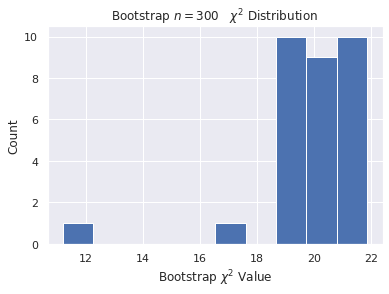

In [16]:
plt.hist(chi_sqrs_series)
plt.xlabel("Bootstrap $\chi^2$ Value")
plt.ylabel("Count")
plt.title("Bootstrap $n=300$   $\chi^2$ Distribution")
plt.savefig("/home/cz136/project/balrog/data/bootstrap/300/n_300_chi_sqr")

In [55]:
chi_sqrs_series.describe()

count    31.000000
mean     19.955827
std       1.867733
min      11.203054
25%      19.565794
50%      20.106847
75%      21.152678
max      21.858996
dtype: float64